--- 1. Libraries Loaded Successfully ---
--- 2. Downloading Data... ---
--- 3. Data Ready: 2139 rows ---
--- 4. Training Models (Please Wait)... ---
   - Logistic Regression Trained


C:\Users\alber\AppData\Local\Temp\ipykernel_2504\3796750715.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2020-01-01', end='2025-11-16', progress=False)


   - SVM Trained
   - Random Forest Trained

🏆 FINAL RESULTS (Accuracy on 2025 Data) 🏆
Logistic Regression: 0.8401
SVM:                 0.8401
Random Forest:       0.7712

--- Random Forest Report (The Likely Winner) ---
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       268
           1       0.19      0.14      0.16        51

    accuracy                           0.77       319
   macro avg       0.52      0.51      0.51       319
weighted avg       0.74      0.77      0.75       319



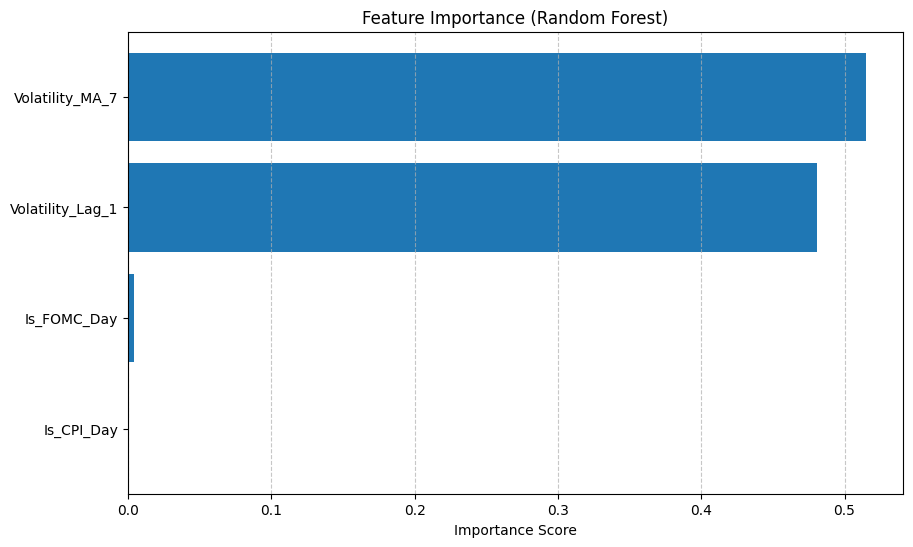

In [ ]:
# does EVERYTHING: Data, Training, and Plotting.
# No LightGBM. No Seaborn. No CSV loading issues.


import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

print("--- 1. Libraries Loaded Successfully ---")

# === PART 1: GET DATA ===
print("--- 2. Downloading Data... ---")
data = yf.download('BTC-USD', start='2020-01-01', end='2025-11-16', progress=False)
data.index = pd.to_datetime(data.index)

# Define Volatility
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['Volatility'] = data['Log_Return'].abs()

# Define Target (Next Day High Volatility)
vol_threshold = data['Volatility'].quantile(0.75)
data['Is_High_Vol_Tomorrow'] = (data['Volatility'].shift(-1) > vol_threshold).astype(int)

# Define Features
fomc_dates = pd.to_datetime([
    '2020-01-29', '2020-03-15', '2020-04-29', '2020-06-10', '2020-07-29', '2020-09-16', '2020-11-05', '2020-12-16',
    '2021-01-27', '2021-03-17', '2021-04-28', '2021-06-16', '2021-07-28', '2021-09-22', '2021-11-03', '2021-12-15',
    '2022-01-26', '2022-03-16', '2022-05-04', '2022-06-15', '2022-07-27', '2022-09-21', '2022-11-02', '2022-12-14',
    '2023-02-01', '2023-03-22', '2023-05-03', '2023-06-14', '2023-07-26', '2023-09-20', '2023-11-01', '2023-12-13',
    '2024-01-31', '2024-03-20', '2024-05-01', '2024-06-12', '2024-07-31', '2024-09-18', '2024-11-07', '2024-12-18',
    '2025-01-29', '2025-03-19', '2025-05-07', '2025-06-18', '2025-07-30', '2025-09-17', '2025-11-05', '2025-12-17'
])
data['Is_FOMC_Day'] = data.index.isin(fomc_dates).astype(int)
data['Is_CPI_Day'] = 0 # Simplified for safety
data['Volatility_Lag_1'] = data['Volatility'].shift(1)
data['Volatility_MA_7'] = data['Volatility'].rolling(window=7).mean()

# Clean
model_data = data.dropna()
print(f"--- 3. Data Ready: {len(model_data)} rows ---")

# === PART 2: TRAIN MODELS ===
print("--- 4. Training Models (Please Wait)... ---")

# Split
train_data = model_data.loc['2020-01-08':'2024-12-31']
test_data = model_data.loc['2025-01-01':]

feature_cols = ['Is_FOMC_Day', 'Is_CPI_Day', 'Volatility_Lag_1', 'Volatility_MA_7']
target_col = 'Is_High_Vol_Tomorrow'

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Scale (Needed for SVM/Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store results
results = {}

# Model 1: Logistic Regression
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
print("   - Logistic Regression Trained")

# Model 2: SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42) 
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
print("   - SVM Trained")

# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("   - Random Forest Trained")

# === PART 3: SHOW RESULTS ===
print("\n" + "="*30)
print("🏆 FINAL RESULTS (Accuracy on 2025 Data) 🏆")
print("="*30)
print(f"Logistic Regression: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"SVM:                 {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Random Forest:       {accuracy_score(y_test, y_pred_rf):.4f}")

print("\n--- Random Forest Report (The Likely Winner) ---")
print(classification_report(y_test, y_pred_rf))

# === PART 4: PLOT FEATURE IMPORTANCE ===
importances = rf_model.feature_importances_
names = feature_cols

# Sort them
sorted_idx = np.argsort(importances)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, importances[sorted_idx], align='center')
plt.yticks(pos, np.array(names)[sorted_idx])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()